# Investigating UFO Sighting Reports
## - By Sakshat Rao

For this analysis, I am using a dataset containing approximately 90000 UFO Sighting details. The dataset contains the textual report, geographical details of the sighting spot and other additional information like duration and shape of the possible UFO.

It is possible to analyze the geography and time series of UFO sightings; in fact there is this [nice analysis](https://www.kaggle.com/ricardoxp1/spatial-analysis-of-ufo-sightings-on-us) which looks at spatial autocorrelation among different states of USA for different time periods. However, for my purpose, I wanted to analyze the textual reports and try to gain some insights about the UFO sightings through these reports.

This is a small analysis aimed at making use of NLP techniques to extract relevant information from this huge stack of textual reports. The analysis is not perfect as I have made and mentioned few assumptions during the course of this analysis. However, my main objective is to show how NLP can possibly be used with the reports to answer certain valid questions.

## Table of Content
1. [Extracting UFO-specific Word Embeddings](#1)
2. [Visualizing the shape and color of UFO sightings](#2)
3. [Measuring level of detail of reports](#3)
4. [Quantifying Durations](#4)

In [1]:
!pip install word2number
!pip install webcolors==1.3

import numpy as np
import pandas as pd

import os
import re
import math
from word2number import w2n
import webcolors
from time import time
from collections import defaultdict, Counter
from tqdm.notebook import tqdm

import scipy.stats as stats

import spacy
import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Circle, Ellipse, Polygon

  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5586 sha256=fb093fa0e166e988e4b462572a4106ecd0e4083e96cf0a3a55c5fa43a5c73671
  Stored in directory: /root/.cache/pip/wheels/4b/c3/77/a5f48aeb0d3efb7cd5ad61cbd3da30bbf9ffc9662b07c9f879
Successfully built word2number
  Created wheel for webcolors: filename=webcolors-1.3-py3-none-any.whl size=13008 sha256=1394cc41bb0ad04484c66dae81f0de066f7766b5f2e69e5fb73b39ad4b1005ed
  Stored in directory: /root/.cache/pip/wheels/49/2e/e7/5078ca745677e53dae9856cf41c114b7b91ada9d5f4d1a8d54
Successfully built webcolors


In [2]:
raw_data = pd.read_csv('/kaggle/input/ufo-sightings-approx-100000/nuforc_reports.csv', usecols = ['city', 'state', 'date_time', 'shape', 'duration', 'text', 'city_latitude', 'city_longitude'], parse_dates = ['date_time'], infer_datetime_format = True)
raw_data.head()

,city,state,date_time,shape,duration,text,city_latitude,city_longitude
0,Chester,VA,2019-12-12 18:43:00,light,5 seconds,My wife was driving southeast on a fairly popu...,37.343152,-77.408582
1,Rocky Hill,CT,2019-03-22 18:30:00,circle,3-5 seconds,I think that I may caught a UFO on the NBC Nig...,41.664800,-72.639300
2,NaN,NaN,NaT,NaN,NaN,I woke up late in the afternoon 3:30-4pm. I w...,NaN,NaN
3,Ottawa,ON,2019-04-17 02:00:00,teardrop,10 seconds,I was driving towards the intersection of fall...,45.381383,-75.708501
4,Peoria,NY,2009-03-15 18:00:00,cigar,2 minutes,"In Peoria, Arizona, I saw a cigar shaped craft...",NaN,NaN


## Word2Vec Embeddings <a id="1"></a>
### Extracting UFO-specific Word Embeddings
---
The main idea here is to obtain embeddings or vector representations of different words and thus find relationships, similarities and commonness among all words. One option is to use pre-trained word embeddings like GloVe, FastText, etc. These embeddings have been obtained after training on extraordinary amounts of data. However, it might be a better idea to create our own word embeddings because of three reasons - 
1. UFO Sightings are reported by common people, hence the vocabulary used may not necessarily be the same as in news or scientific reports. In other words, several informal/slang terms may not be present in the pre-trained word embeddings.
2. There may be several words specific to UFOs which may not be present in the pre-trained word embeddings. Examples could include shortforms like 'et' (standing for extraterrestrial).
3. There are around 90000 reports available. Although not large, it is a decent enough amount to train word embeddings and obtain satisfactory performance.

In [3]:
# nlp = spacy.load('en', disable=['ner', 'parser'])

# def cleaning(doc):
#     txt = [token.lemma_ for token in doc if not token.is_stop]
#     if len(txt) > 2:
#         return ' '.join(txt)

# brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in raw_data['text'])

# t = time()
# txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
# print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

# df_clean = pd.DataFrame({'clean': txt})
# df_clean = df_clean.dropna().drop_duplicates()

# df_clean = df_clean.reset_index(drop = False)
# df_clean.to_csv('cleaned_ufo_texts.csv', index = False)

# sent = [row.split() for row in df_clean['clean']]
# phrases = Phrases(sent, min_count=30, progress_per=10000)
# bigram = Phraser(phrases)
# sentences = bigram[sent]

# word_freq = defaultdict(int)
# for sent in sentences:
#     for i in sent:
#         word_freq[i] += 1
# print(f"No. of words - {len(word_freq)}")
# print("Most frequent words - ")
# print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])

# cores = multiprocessing.cpu_count()
# w2v_model = Word2Vec(
#     min_count=20,
#     window=3,
#     vector_size=300,
#     sample=6e-5, 
#     alpha=0.03, 
#     min_alpha=0.0007, 
#     negative=20,
#     workers=cores-1
# )

# t = time()
# w2v_model.build_vocab(sentences, progress_per=10000)
# print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

# t = time()
# w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
# print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# w2v_model.init_sims(replace=True)
# w2v_model.save("ufo_text.model")

w2v_model_new = Word2Vec.load("/kaggle/input/ufo-word2vec/ufo_text.model")

def show_similar_words(words, target_word):
    print(f"Words most similar to {target_word}:")
    for word_idx, word in enumerate(words):
        print(f"{word_idx+1}. {word[0]}", end = '')
        for x in range(20 - len(word[0])):
            print(' ', end = '')
        if(word_idx % 3 == 2):
            print()
    print('\n')

We extract the Word2Vec word embeddings and try to find which words are similar to different keywords. The keywords I have used here are 'ufo', 'alien', 'spaceship' and 'light'.

In [4]:
show_similar_words(w2v_model_new.wv.most_similar(positive=["ufo"]), "ufo")

Words most similar to ufo:
1. ufos                2. believe             3. documentary         
4. alien               5. aliens              6. history_channel     
7. report              8. firm_believer       9. sighting            
10. extraterrestrial    



### We find two really interesting words which are apparently similar to UFO - documentary and history_channel.

For those unaware, **History Channel** has run shows like 'Ancient Aliens' and a few more which deal with the possibility of humans already contacting aliens. There are several other shows and **documentaries** which explore this possibility.

So is it fair to say that UFO sightings could have been boosted by the increased attention towards these shows? After all, these word embeddings were trained on UFO reports and they mention history_channel and documentary as being similar to UFOs.

There is a condition in medical science that I would like to mention here called [Medical Student's Disease](https://en.wikipedia.org/wiki/Medical_students%27_disease). It is a condition where medical students feel they are having a disease which they are currently studying. This happens because students have studied about the disease and its symptoms very well and this causes increased awareness and fear about this disease. As a result, sometimes they could confuse their normal bodily sensations as symptoms of the disease.

Could it be possible that the public also face a similar condition? Watching shows related to UFOs raises their awareness and makes them fearful about it. As a result, they may confuse normal and innocent situations/objects as being weird and extraterrestrial.

In [5]:
show_similar_words(w2v_model_new.wv.most_similar(positive=["alien"]), "alien")

Words most similar to alien:
1. aliens              2. believe_alien       3. extra_terrestrial   
4. demon               5. extraterrestrial    6. being               
7. extraterrestial     8. abduct              9. ufo                 
10. et                  



### Abduct seems to be similar to alien

This holds well with several reports of people claiming they were abducted by aliens

In [6]:
show_similar_words(w2v_model_new.wv.most_similar(positive=["spaceship"]), "spaceship")

Words most similar to spaceship:
1. alien               2. sci_fi              3. ship                
4. science_fiction     5. independence_day    6. star_trek           
7. mother_ship         8. fairy               9. coz                 
10. being               



### Sci-fi movies seem to have similarities with spaceship

We find two movies similar to spaceship - Independence Day & Star Trek. [Independence Day](https://en.wikipedia.org/wiki/Independence_Day_(1996_film)) is a 1996 film with an alien invasion and an enormous alien mothership at the core of its plot. [Star Trek](https://en.wikipedia.org/wiki/Star_Trek) on the other hand is not exactly about alien invasion, but nonetheless involves several spaceships like the famous starship USS Enterprise.

It makes sense that both movies involve spaceships and are apparently similar to 'spaceship'. Again, we can make a similar argument here about the popularity of such sci-fi films and the depiction of UFOs in them boosting UFO sightings.

In [7]:
show_similar_words(w2v_model_new.wv.most_similar(positive=["light"]), "light")

Words most similar to light:
1. red                 2. white               3. bright              
4. flash               5. blink               6. yellow              
7. flashing            8. appear              9. green               
10. dim                 



### Red, white, yellow and green seem to be the most common colors of 'UFO lights' while bright, flash, blink and dim seem to be the most common characteristics of 'UFO lights'

It is fascinating to see so much information about UFO lights being obtained from these word embeddings. We can apparently infer not only the colour but also the motion of these UFO lights.

In the dataset, the colour of UFO sightings is not mentioned as a column. However, it seems we can extract that from the textual reports. We will be doing that for the next section.

## UFO Color & Shape Analysis <a id="2"></a>
### Visualizing the shape and color of UFO sightings
---
We shall now extract colors of all UFO sightings from the corresponding report and after pairing them with the shape of the UFO, we can look at the most common UFO sightings.

Most frequent colors:
1. white               2. red                 3. orange              
4. blue                5. green               6. black               
7. yellow              8. silver              9. grey                
10. gray                



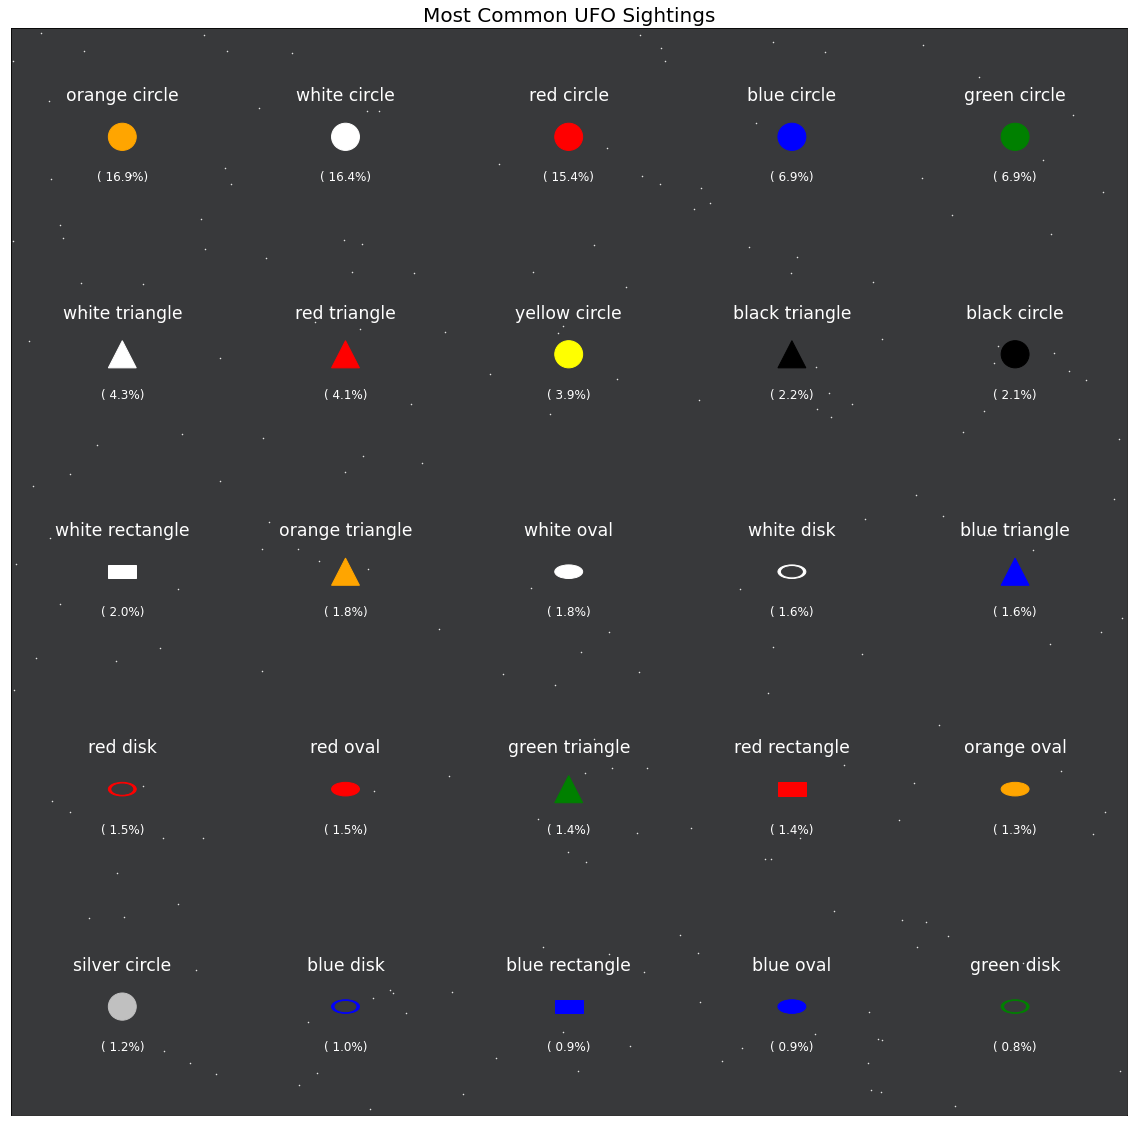

In [8]:
df_clean = pd.read_csv('/kaggle/input/cleaned-ufo-texts/cleaned_ufo_texts.csv')
df_clean = df_clean.set_index('index')

possible_colors = webcolors.css3_names_to_hex
# colors = np.zeros((df_clean.shape[0], len(possible_colors)), dtype = np.bool)
# for idx, row in tqdm(df_clean.iterrows(), total = df_clean.shape[0]):
#     for color_idx, color in enumerate(possible_colors):
#         if(pd.isnull(row['clean'])):
#             continue
#         if(re.search(r"\b" + re.escape(color) + r"\b", row['clean'], flags = re.I)):
#             colors[idx, color_idx] = 1

# with open('ufo_colors.npy', 'wb') as save_file:
#     np.save(save_file, colors)

with open('/kaggle/input/ufo-colors-list/ufo_colors.npy', 'rb') as load_file:
    colors = np.load(load_file)

def show_frequent_colors(colors):
    print("Most frequent colors:")
    for color_idx, color in enumerate(colors):
        print(f"{color_idx+1}. {color[0]}", end = '')
        for x in range(20 - len(color[0])):
            print(' ', end = '')
        if(color_idx % 3 == 2):
            print()
    print('\n')
show_frequent_colors(sorted(list(zip(possible_colors, np.sum(colors, axis = 0))), key = lambda x: x[1], reverse = True)[:10])

shape_mapping = {
    'light': 'circle',
    'circle': 'circle',
    'teardrop': 'teardrop',
    'cigar': 'rectangle',
    'disk': 'disk',
    'unknown': 'unknown',
    'oval': 'oval',
    'other': 'unknown',
    'sphere': 'circle',
    'changing': 'unknown',
    'formation': 'unknown',
    'flash': 'circle',
    'chevron': 'triangle',
    'triangle': 'triangle',
    'cylinder': 'rectangle',
    'fireball': 'circle',
    'diamond': 'diamond',
    'egg': 'oval',
    'cross': 'cross',
    'rectangle': 'rectangle',
    'cone': 'triangle'
}
raw_data['shape'] = raw_data['shape'].fillna('unknown')
raw_data['shape'] = raw_data['shape'].map(shape_mapping)

colors_df = pd.DataFrame(colors, index = df_clean.index, columns = possible_colors)
shape_color_df = pd.merge(colors_df, raw_data, how = 'left', left_index = True, right_index = True)

possible_shape_color_pairs = []
for idx, row in shape_color_df.iterrows():
    for color in possible_colors:
        if(row[color] == True):
            possible_shape_color_pairs.append((row['shape'], color))
possible_shape_color_pairs = Counter([x for x in possible_shape_color_pairs if x[0] != 'unknown']).most_common()[:25]
tot_sum = np.sum([x[1] for x in possible_shape_color_pairs])

fig, ax = plt.subplots(1, 1, figsize = (20, 20))

for y_pos in range(4, -1, -1):
    for x_pos in range(5):
        idx = (4 - y_pos) * 5 + x_pos
        if(possible_shape_color_pairs[idx][0][0] == 'circle'):
            # Circle
            ax.add_patch(Circle((x_pos * 4 + 2, y_pos * 4 + 2), 0.25, color = possible_shape_color_pairs[idx][0][1]))
        elif(possible_shape_color_pairs[idx][0][0] == 'rectangle'):
            # Rectange
            ax.add_patch(Rectangle((x_pos * 4 + 2 - 0.25, y_pos * 4 + 2 - 0.25 / 2), 0.5, 0.25, color = possible_shape_color_pairs[idx][0][1]))
        elif(possible_shape_color_pairs[idx][0][0] == 'triangle'):
            # Triangle
            ax.add_patch(Polygon([[x_pos * 4 + 2 - 0.25, y_pos * 4 + 2 - 0.25], [x_pos * 4 + 2, y_pos * 4 + 2 + 0.25], [x_pos * 4 + 2 + 0.25, y_pos * 4 + 2 - 0.25]], color = possible_shape_color_pairs[idx][0][1]))
        elif(possible_shape_color_pairs[idx][0][0] == 'oval'):
            # Oval
            ax.add_patch(Ellipse((x_pos * 4 + 2, y_pos * 4 + 2), 0.5, 0.25, color = possible_shape_color_pairs[idx][0][1]))
        elif(possible_shape_color_pairs[idx][0][0] == 'disk'):
            # Disk
            ax.add_patch(Ellipse((x_pos * 4 + 2, y_pos * 4 + 2), 0.5, 0.25, color = possible_shape_color_pairs[idx][0][1]))
            ax.add_patch(Ellipse((x_pos * 4 + 2, y_pos * 4 + 2), 0.75 / 2, 0.75 / 4, color = '#38393b'))
        else:
            pass
        ax.annotate(f"{possible_shape_color_pairs[idx][0][1]} {possible_shape_color_pairs[idx][0][0]}", (x_pos * 4 + 2, y_pos * 4 + 4 - 1.25), ha = 'center', va = 'center', color = 'white', fontsize = 'xx-large')
        ax.annotate(f"({possible_shape_color_pairs[idx][1] * 100 / tot_sum: .1f}%)", (x_pos * 4 + 2, y_pos * 4 + 1.25), ha = 'center', va = 'center', color = 'white', fontsize = 'large')

stars = np.random.uniform(low = 0, high = 20, size = (200, 2))
ax.scatter(stars[:, 0], stars[:, 1], color = 'white', s = 0.25)

ax.set_facecolor('#38393b')
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Most Common UFO Sightings", fontsize = 20)
plt.show()

### The most frequent colors are white, red & orange

This partially holds true with respect to the UFO colours obtained from the word embeddings since red and white are common to both of them.

### Orange Circles seem to be the most common UFO sighting

I have plotted the top 25 most common UFO sightings. Do note that this is not perfect since solely searching for colors in the textual reports does not guarantee that the color is being used to describe UFOs. For example, if the report contains a text like - "Through the green leaves, I suddenly saw a bright white light", then simply searching for colors in the text will make it appear as the UFO sighting was green & white in color. One solution for that is to use advanced NLP and only choose those colors which seem to describe UFOs.

## Level of Detail in Reports <a id="3"></a>
---
Now unfortunately, there is no information available about which UFO sighting is true and which is false. And it doesn't look possible to even have this information.

One method of trying to predict fakeness in UFO sightings is to analyze the level of detail in the report. Often fake news contains content which is not descriptive, informative or comprehensive. Detailed content is often a decent indicator of true news. Applying a similar idea, we can analyze the level of detail in the UFO sighting reports. Having a vague, non-descriptive report could be a decent indicator of a fake UFO sighting. A descriptive report obviously cannot guarantee an actual UFO sighting and additional investigation would definitely be required.

For this analysis, I am keeping it simple and equating level of detail to the addition of two terms - 
1. Size of report (number of non-stopwords)
2. Number of adjectives in report

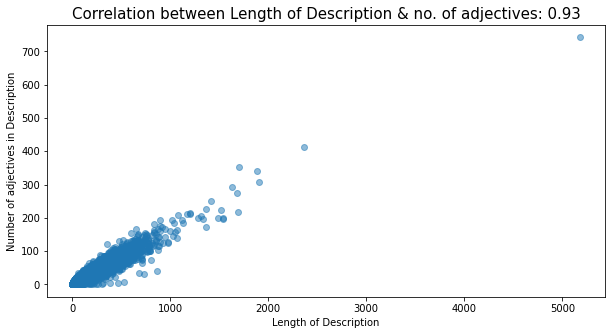



UFO Sighting Descriptions with least detail:

" There are currently lights over the golf coast in Naples Florida. "
" UFO over highway in Orlando, Florida, April 1st 2012! "
" Triangle shape,,,changing colors,,,then broke into 3 orbs. "
" Shape with lights hovering then inching then speeding in a direction. "
" sited just below where the Orion Nebula would be 2 sets of 3 orange spheres "
" Saw at first one pulsating sphere.  Then a secound.  Both moving very aratctly. "
" watching fireworks  something went accross the sky very fast "
" Series of orangeish lights appear and disappear all over sky. "
" Four orange lights moving southeast and disappeared into the sky. "
" They moved back and forth up and down right and left then landed behind the trees "


In [9]:
# df_clean['length'] = df_clean['clean'].apply(lambda x: len(x.split(' ')))
# nlp = spacy.load('en', disable=['ner', 'parser'])
# # adjective_pos = ['JJ', 'JJR', 'JJS']
# adjectives = np.zeros(raw_data.shape[0])
# for idx, row in tqdm(raw_data.iterrows(), total = raw_data.shape[0]):
#     if(pd.isnull(row['text'])):
#         continue
#     adjectives[idx] = len([x.string for x in nlp(row['text']) if x.pos_ == 'ADJ'])
# raw_data['num_adjectives'] = pd.Series(adjectives, index = raw_data.index)
# detail_df = pd.merge(df_clean, raw_data, how = 'left', left_index = True, right_index = True)[['length', 'num_adjectives']]
# detail_df = detail_df.reset_index(drop = False)
# detail_df.to_csv('detail.csv', index = False)

detail_df = pd.read_csv('/kaggle/input/ufo-sighting-description-detail/detail.csv')
corr_val = detail_df[['length', 'num_adjectives']].corr().values[0, 1]

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.scatter(x = detail_df['length'], y = detail_df['num_adjectives'], alpha = 0.5)
ax.set_xlabel("Length of Description", fontsize = 10)
ax.set_ylabel("Number of adjectives in Description", fontsize = 10)
ax.set_title(f"Correlation between Length of Description & no. of adjectives: {corr_val:.2f}", fontsize = 15)
plt.show()

length_mean = detail_df['length'].mean(); length_std = detail_df['length'].std()
num_adj_mean = detail_df['num_adjectives'].mean(); num_adj_std = detail_df['num_adjectives'].std()
detail_df['detail_score'] = detail_df.apply(lambda x: ((x['length'] - length_mean) / length_std) + (x['num_adjectives'] - num_adj_mean) / num_adj_std, axis = 1)

print("\n\nUFO Sighting Descriptions with least detail:\n")
for idx in detail_df[detail_df['detail_score'] < np.quantile(detail_df['detail_score'], 0.001)].sort_values('length', ascending = False).iloc[:10]['index']:
    print('" ' + raw_data.loc[idx]['text'] + ' "')

As I was expecting, the length of the report and the number of adjectives in it is highly correlated which probably means we don't even need to use both of them. It is also evident from the graph that almost all reports have less than 2000 words with certain exceptions having as many as 5000 words.

I have also displayed few reports which I found to have least level of detail. They contain very few non-stopwords and almost no adjectives which really does put a question mark over their validity.

A few ways to better capture level of detail could be to also count proper nouns or even by checking for missing values for other data variables like time of reporting, shape of UFO and location of sighting.

## Quantifying Duration <a id="4"></a>
---
As some of you might have noticed, the duration variable is actually a string. We do not have numerical values like 5, 60 & 300; instead we have strings like 'about 5 seconds', '1 minute roughly' & '5min'. Converting those strings to numbers is extremely difficult since there are a lot of cases to consider. With basic regular expression knowledge, I was able to approximately quantify most of the 90000 durations (except ~6500). I treated words like 'many', 'few', etc. to be treated as 2 for convenience - that is, I treated durations like 'few minutes' as 2 minutes to keep it simple.

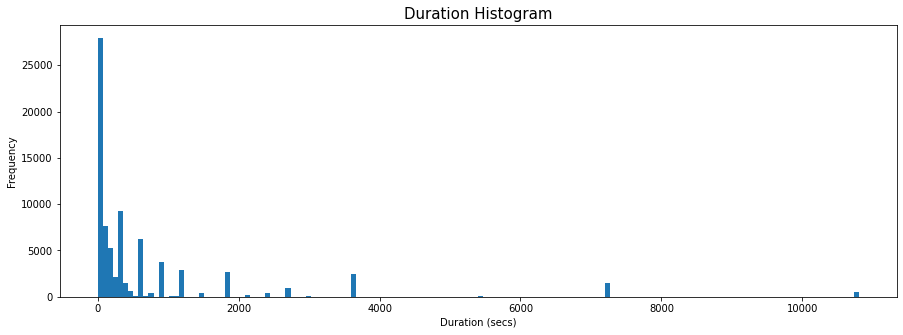


Average duration:  11.7 minutes
Most frequent duration:  5.0 minutes (appearing  11.9% times)


In [10]:
def convert_text_into_numbers(x):
    if(type(x) == float):
        return x
    else:
        x = x.strip()
        x = re.sub(r"\+", "", x, flags = re.I)
        x = re.sub(r",", "", x, flags = re.I)
        x = re.sub(r"\?", "", x, flags = re.I)
        x = re.sub(r"approx.", "", x, flags = re.I)
        x = re.sub(r"approximately", "", x, flags = re.I)
        x = x.strip()
        
        x = re.sub(r"secound", 'second', x, flags = re.I)
        x = re.sub(r"secend", 'second', x, flags = re.I)
        x = re.sub(r"secopnd", 'second', x, flags = re.I)
        x = re.sub(r"minet", 'minute', x, flags = re.I)
        x = re.sub(r"minit", 'minute', x, flags = re.I)
        x = re.sub(r"miute", 'minute', x, flags = re.I)
        x = re.sub(r"mnute", "minute", x, flags = re.I)
        x = re.sub(r"minuet", "minute", x, flags = re.I)
        x = re.sub(r"minuite", "minute", x, flags = re.I)
        x = re.sub(r"mintue", "minute", x, flags = re.I)
        x = re.sub(r"minut[s]*$", "minute", x, flags = re.I)
        x = re.sub(r"minuto", "minute", x, flags = re.I)
        x = re.sub(r"mineut", "minute", x, flags = re.I)
        x = re.sub(r"mimit", "minute", x, flags = re.I)
        x = re.sub(r"minte", "minute", x, flags = re.I)
        x = re.sub(r"minuit", "minute", x, flags = re.I)
        
        x = re.sub(r"sec[s]*[\.]*$", 'second', x, flags = re.I)
        x = re.sub(r"(\d+s)$", r'\1econd', x, flags = re.I)
        x = re.sub(r"min[s]*[\.]*$", "minute", x, flags = re.I)
        x = re.sub(r"(\d+m)$", r'\1inute', x, flags = re.I)
        x = re.sub(r"hr[s]*[\.]*$", "hour", x, flags = re.I)
        x = re.sub(r"(\d+h)$", r'\1our', x, flags = re.I)
        
        x = re.sub(r"zero", "0", x, flags = re.I)
        x = re.sub(r"one", "1", x, flags = re.I)
        x = re.sub(r"two", "2", x, flags = re.I)
        x = re.sub(r"three", "3", x, flags = re.I)
        x = re.sub(r"four", "4", x, flags = re.I)
        x = re.sub(r"five", "5", x, flags = re.I)
        x = re.sub(r"six", "6", x, flags = re.I)
        x = re.sub(r"seven", "7", x, flags = re.I)
        x = re.sub(r"eight", "8", x, flags = re.I)
        x = re.sub(r"nine", "9", x, flags = re.I)
        
        x = re.sub(r"few", "2", x, flags = re.I)
        x = re.sub(r"many", "2", x, flags = re.I)
        x = re.sub(r"several", "2", x, flags = re.I)
        x = re.sub(r"couple", "2", x, flags = re.I)
        x = re.sub(r"mere", "2", x, flags = re.I)
        x = re.sub(r"^a ", "1", x, flags = re.I)
        x = re.sub(r"^an ", "1", x, flags = re.I)
        x = re.sub(r" a ", "1", x, flags = re.I)
        x = re.sub(r" an ", "1", x, flags = re.I)
        
        x = re.sub(r"^second$", "1 second", x, flags = re.I)
        x = re.sub(r"^minute$", "1 minute", x, flags = re.I)
        x = re.sub(r"^hour$", "1 hour", x, flags = re.I)
        x = re.sub(r"^seconds$", "2 second", x, flags = re.I)
        x = re.sub(r"^minutes$", "2 minute", x, flags = re.I)
        x = re.sub(r"^hours$", "2 hour", x, flags = re.I)
        
        new_x = []
        add_words = False
        for word in x.split(' '):
            try:
                new_word = str(w2n.word_to_num(word))
            except:
                new_word = word
            if(add_words == True):
                new_x.append(new_word)
            elif(new_word.isdigit()):
                add_words = True
                new_x.append(new_word)
        if(add_words == True):
            x = ' '.join(new_x)
        
        return x

def convert_seconds_into_numbers(x):
    if(type(x) == float):
        return x
    else:
        search_x = re.search(r"\d+[ ]*seconds*", x, flags = re.I)
        if(search_x):
            return float(''.join([x for x in search_x.group(0) if x.isdigit()]))
        else:
            return x

def convert_minutes_into_numbers(x):
    if(type(x) == float):
        return x
    else:
        search_x = re.search(r"\d+[ ]*minutes*", x, flags = re.I)
        if(search_x):
            return float(''.join([x for x in search_x.group(0) if x.isdigit()])) * 60
        else:
            return x

def convert_hours_into_numbers(x):
    if(type(x) == float):
        return x
    else:
        search_x = re.search(r"\d+[ ]*hours*", x, flags = re.I)
        if(search_x):
            return float(''.join([x for x in search_x.group(0) if x.isdigit()])) * 3600
        else:
            return x

duration = [convert_text_into_numbers(x) for x in raw_data['duration']]
duration = [convert_seconds_into_numbers(x) for x in duration]
duration = [convert_minutes_into_numbers(x) for x in duration]
duration = [convert_hours_into_numbers(x) for x in duration]

numerical_duration = [x for x in duration if type(x) != str]
numerical_duration = [x for x in numerical_duration if math.isnan(x) == False]
upper_limit = np.quantile(numerical_duration, 0.99)
numerical_duration = [x for x in numerical_duration if x <= upper_limit]

fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.hist(numerical_duration, bins = 150)
ax.set_xlabel("Duration (secs)", fontsize = 10)
ax.set_ylabel("Frequency", fontsize = 10)
ax.set_title("Duration Histogram", fontsize = 15)
plt.show()

print(f"\nAverage duration: {np.mean(numerical_duration) / 60: .1f} minutes")
print(f"Most frequent duration: {stats.mode(numerical_duration).mode[0] / 60: .1f} minutes (appearing {stats.mode(numerical_duration).count[0] / len(numerical_duration) * 100: .1f}% times)")

The durations do have a rather large range of values, ranging from a few seconds to almost 3 hours. In fact, among the ~6500 durations which I wasn't able to quantify, I noticed a few ones like 'overnight' and 'three months' which indicates that the range shown here actually extends way beyond. Also, the most frequent duration mentioned in the reports was 5 minutes (300 seconds).

# Thank You!
---
I hope you enjoyed the analysis! Feel free to check out my code if interested. If you have any suggestions or you wish to point out any mistake which I may have done, do let me know.